# Introduction

In this project, I will build a neural network of my own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking  models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.mps as mps
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset


MNIST is fortunately included in the torchvision module.
I will create the dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).

Once the dataset is created, I'll define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
training_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.RandomRotation(30), transforms.RandomHorizontalFlip()])
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
view_transforms = transforms.Compose([transforms.ToTensor()])


# Create the full MNIST dataset
full_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=None
)
view = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=view_transforms
)

# Split the full dataset into training, validation, and test sets
train_size = int(0.6 * len(full_dataset))
valid_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size

training_data, validation_data, test_data = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size, test_size]
)

# Apply transforms to the datasets
training_data.dataset.transform = training_transforms
validation_data.dataset.transform = test_transforms
test_data.dataset.transform = test_transforms

# Create data loaders for training, validation, and test sets
batch_size = 64

training_loader = torch.utils.data.DataLoader(
    view, batch_size=batch_size, shuffle=True
)

training_loader_view = torch.utils.data.DataLoader(
    training_data, batch_size=batch_size, shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_data, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Justify  preprocessing

**I made tansforms for both training data and test data. For the training data, I transformed to tensor, normalized it, and applied random rotation and random horizontal flip. For the test data, I transformed to tensor and normalized it. I chose these transforms because I wanted to make the training data more diverse and the test data to be as close to the training data as possible. I also normalized the data because it makes the training process faster and more accurate.**

## Explore the Dataset
Using matplotlib, numpy, and torch, I will explore the dimensions of the data.

I will view images using the `show5` function defined below – it takes a data loader as an argument.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training a network.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


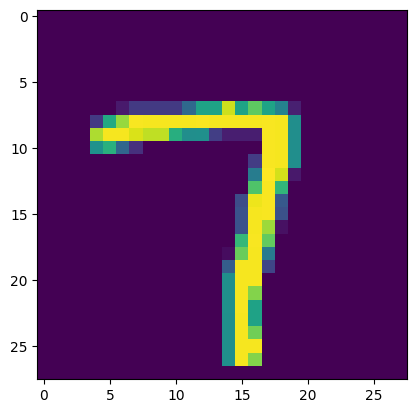

8


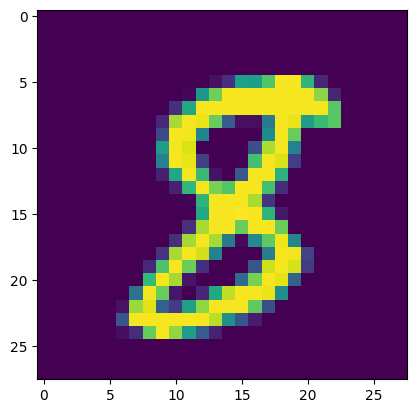

2


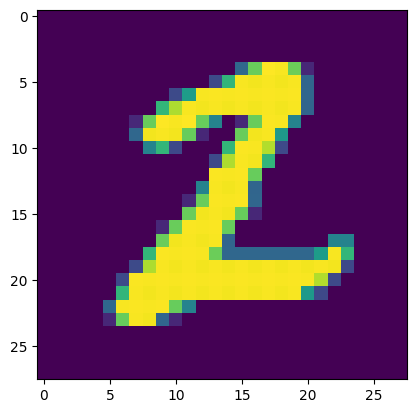

9


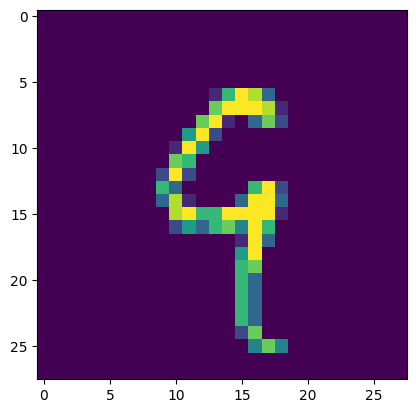

0


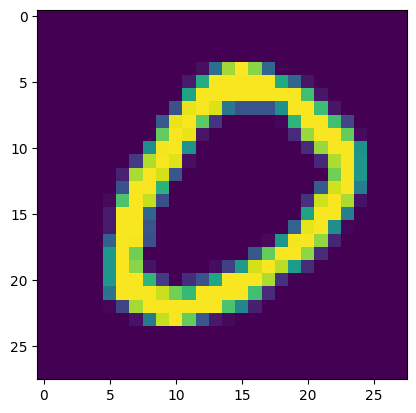

In [6]:
# Explore data
show5(training_loader)

### Using only transform to tensor

0


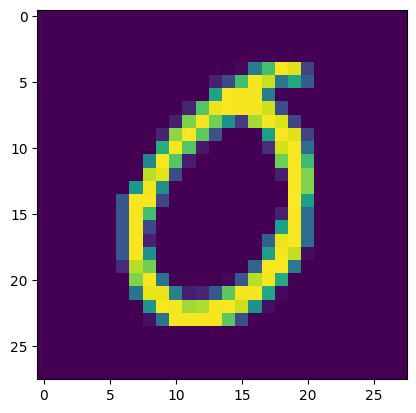

6


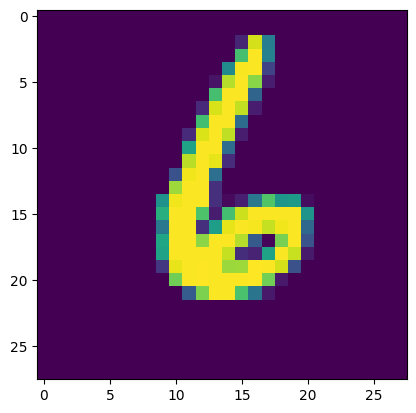

6


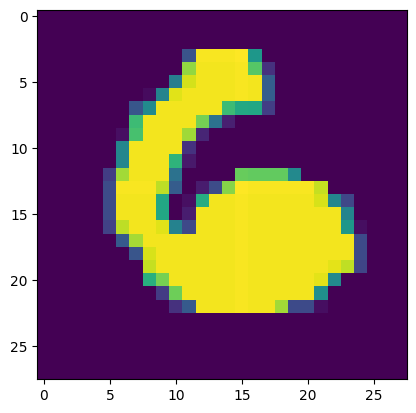

3


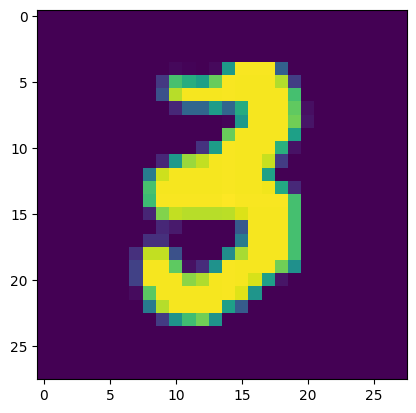

0


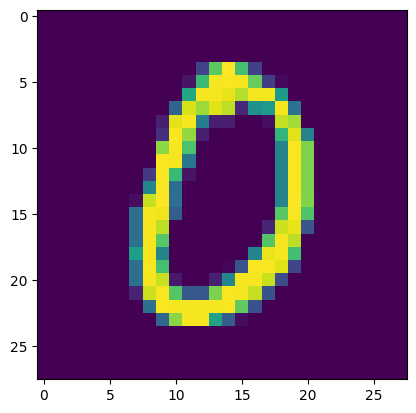

In [7]:
show5(training_loader_view)

##### Using only transform to tensor for training data actually works well for viewing. Normalizing and adding other transforms is not so great for veiwing but is good for training.

### The images are 28x28 pixels, so the input layer will have 784 nodes. The output layer will have 10 nodes, one for each digit. 

## Build  Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), I will construct a neural network based on the parameters of the dataset.

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 7 * 7)  # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

In [9]:
model = CNN()

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# For other devices with CUDA support, pass cuda as the device argument to the model constructor.
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
print(device)

cpu


## Run Neural Network

In [10]:
num_epochs = 15
steps = 0

train_losses, test_losses = [], []
for e in range(num_epochs):
    running_loss = 0
    for inputs, labels in training_loader:
        # Move input and label tensors to the available device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for inputs, labels in test_loader:
                # Move input and label tensors to the available device
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, labels)
                
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)        
        model.train()
        
        train_losses.append(running_loss/len(training_loader))
        test_losses.append(test_loss/len(test_loader))
        print("Epoch: {}/{}.. ".format(e+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]))
print("Trained on ", device)

Epoch: 1/15..  Training Loss: 0.242..  Test Loss: 0.345.. 
Epoch: 2/15..  Training Loss: 0.073..  Test Loss: 0.405.. 
Epoch: 3/15..  Training Loss: 0.051..  Test Loss: 0.366.. 
Epoch: 4/15..  Training Loss: 0.042..  Test Loss: 0.373.. 
Epoch: 5/15..  Training Loss: 0.035..  Test Loss: 0.193.. 
Epoch: 6/15..  Training Loss: 0.030..  Test Loss: 0.259.. 
Epoch: 7/15..  Training Loss: 0.025..  Test Loss: 0.187.. 
Epoch: 8/15..  Training Loss: 0.023..  Test Loss: 0.328.. 
Epoch: 9/15..  Training Loss: 0.020..  Test Loss: 0.074.. 
Epoch: 10/15..  Training Loss: 0.018..  Test Loss: 0.082.. 
Epoch: 11/15..  Training Loss: 0.014..  Test Loss: 0.041.. 
Epoch: 12/15..  Training Loss: 0.014..  Test Loss: 0.052.. 
Epoch: 13/15..  Training Loss: 0.013..  Test Loss: 0.096.. 
Epoch: 14/15..  Training Loss: 0.011..  Test Loss: 0.176.. 
Epoch: 15/15..  Training Loss: 0.010..  Test Loss: 0.129.. 
Trained on  cpu


Plot the training loss.

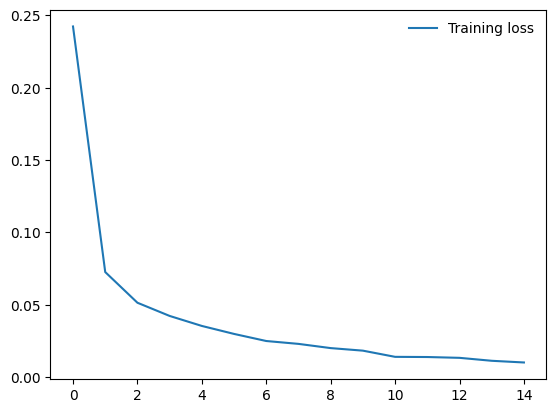

In [11]:
# Plot the training loss
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)
plt.show()

## Testing the model
Using the previously created `DataLoader` for the validation set, I will compute the percentage of correct predictions using the highest probability prediction. 

In [12]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in validation_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on validation set: %d %%' % (100 * correct / total))
        

Accuracy of the network on validation set: 97 %


## Improving the model

Once the model is done training, I'll tweak the hyperparameters and train again below to improve the accuracy on the validation.

In [13]:
#Using a different loss - Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
num_epochs = 15
steps = 0

train_losses, test_losses = [], []
for e in range(num_epochs):
    running_loss = 0
    for inputs, labels in training_loader:
        # Move input and label tensors to the available device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for inputs, labels in test_loader:
                # Move input and label tensors to the available device
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, labels)
                
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)        
        model.train()
        
        train_losses.append(running_loss/len(training_loader))
        test_losses.append(test_loss/len(test_loader))
        print("Epoch: {}/{}.. ".format(e+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]))
print("Trained on ", device)


Epoch: 1/15..  Training Loss: 0.007..  Test Loss: 0.125.. 
Epoch: 2/15..  Training Loss: 0.011..  Test Loss: 0.075.. 
Epoch: 3/15..  Training Loss: 0.010..  Test Loss: 0.080.. 
Epoch: 4/15..  Training Loss: 0.008..  Test Loss: 0.085.. 
Epoch: 5/15..  Training Loss: 0.007..  Test Loss: 0.053.. 
Epoch: 6/15..  Training Loss: 0.008..  Test Loss: 0.062.. 
Epoch: 7/15..  Training Loss: 0.007..  Test Loss: 0.071.. 
Epoch: 8/15..  Training Loss: 0.007..  Test Loss: 0.059.. 
Epoch: 9/15..  Training Loss: 0.006..  Test Loss: 0.070.. 
Epoch: 10/15..  Training Loss: 0.006..  Test Loss: 0.083.. 
Epoch: 11/15..  Training Loss: 0.007..  Test Loss: 0.072.. 
Epoch: 12/15..  Training Loss: 0.007..  Test Loss: 0.045.. 
Epoch: 13/15..  Training Loss: 0.006..  Test Loss: 0.136.. 
Epoch: 14/15..  Training Loss: 0.006..  Test Loss: 0.075.. 
Epoch: 15/15..  Training Loss: 0.005..  Test Loss: 0.090.. 
Trained on  cpu


In [14]:
# Check Accuracy for new model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on validation set: %d %%' % (100 * correct / total))

Accuracy of the network on validation set: 98 %


## Saving the model
Using `torch.save` to save the model for future loading.

In [15]:
#saving the model
torch.save(model.state_dict(), 'checkpoint.pth')